In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from glob import glob

K.tensorflow_backend._get_available_gpus()

base_dir = r'C:\Users\Vítor\Documents\TCC\Banco de Dados\Imagens The Deep censurado\Axial'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

Using TensorFlow backend.


In [2]:
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
#Criando a CNN
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 256)       590080    
__________

In [4]:
from keras import optimizers

# SGD (Descida do Gradiente Estocástico) - Otimizador 
momentum = 0.5
sgd = optimizers.SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False) 

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
from keras.preprocessing.image import ImageDataGenerator


# Todas as imagens em nova scale
gen = ImageDataGenerator(rescale=1./255,  width_shift_range=0.2,  
    height_shift_range=0.2,
    horizontal_flip=True)


train_generator = gen.flow_from_directory(
        
        train_dir,
        # Todas as images para novo tamanho de 150x150
        target_size=(150, 150),
        batch_size=20,
        shuffle=True,
        # Como foi usado a perda binary_crossentropy, precisamos de rótulos binários
        class_mode='binary')

validation_generator = gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=True,
        class_mode='binary')

test_generator = gen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=True,
        class_mode='binary')

Found 6716 images belonging to 2 classes.
Found 1439 images belonging to 2 classes.
Found 1440 images belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [7]:
import math
def step_decay(epoch):
    
    
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
   

lrate = LearningRateScheduler(step_decay)
callbacks_list = [ lrate]

In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=50)




Epoch 1/30
100/100 [==============================] - 81s 809ms/step - loss: 0.6792 - acc: 0.5920 - val_loss: 0.6834 - val_acc: 0.5870
Epoch 2/30
100/100 [==============================] - 67s 666ms/step - loss: 0.6839 - acc: 0.5675 - val_loss: 0.6872 - val_acc: 0.5616
Epoch 3/30
100/100 [==============================] - 57s 572ms/step - loss: 0.6777 - acc: 0.5775 - val_loss: 0.6998 - val_acc: 0.4334
Epoch 4/30
100/100 [==============================] - 45s 448ms/step - loss: 0.6714 - acc: 0.5968 - val_loss: 0.6865 - val_acc: 0.5850
Epoch 5/30
100/100 [==============================] - 43s 426ms/step - loss: 0.6721 - acc: 0.5835 - val_loss: 0.6900 - val_acc: 0.5145
Epoch 6/30
100/100 [==============================] - 43s 427ms/step - loss: 0.6624 - acc: 0.5925 - val_loss: 0.7260 - val_acc: 0.4655
Epoch 7/30
100/100 [==============================] - 42s 422ms/step - loss: 0.6609 - acc: 0.5935 - val_loss: 0.7153 - val_acc: 0.4480
Epoch 8/30
100/100 [==============================] - 4

In [9]:
test_gen = gen.flow_from_directory(test_dir, target_size=(150,150))
print(test_gen.class_indices)

Found 1440 images belonging to 2 classes.
{'autista': 0, 'controle': 1}


In [10]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=(150,150), shuffle=False, batch_size=80):
        i += 1
        if i % 500 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_dir, 6716)
print(cm)
valid_cm = get_confusion_matrix(validation_dir, 1439)
print(valid_cm)

Generating confusion matrix 6716
Found 6716 images belonging to 2 classes.
[[3888    0]
 [2828    0]]
Generating confusion matrix 1439
Found 1439 images belonging to 2 classes.
[[833   0]
 [606   0]]


In [11]:
import matplotlib.pyplot as plt

accTR = history.history['acc']
val_acc = history.history['val_acc']
lossTR = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accTR))

In [12]:
history = model.fit_generator(
      test_generator,
      steps_per_epoch=100,
      epochs=30,
      callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 84s 843ms/step - loss: 0.6679 - acc: 0.6020
Epoch 2/30
100/100 [==============================] - 36s 362ms/step - loss: 0.6270 - acc: 0.6450
Epoch 3/30
100/100 [==============================] - 36s 358ms/step - loss: 0.5601 - acc: 0.6900
Epoch 4/30
100/100 [==============================] - 36s 360ms/step - loss: 0.5560 - acc: 0.7030
Epoch 5/30
100/100 [==============================] - 36s 358ms/step - loss: 0.5380 - acc: 0.7200
Epoch 6/30
100/100 [==============================] - 36s 358ms/step - loss: 0.4987 - acc: 0.7475
Epoch 7/30
100/100 [==============================] - 36s 361ms/step - loss: 0.4996 - acc: 0.7450
Epoch 8/30
100/100 [==============================] - 36s 358ms/step - loss: 0.4900 - acc: 0.7485
Epoch 9/30
100/100 [==============================] - 36s 359ms/step - loss: 0.4590 - acc: 0.7710
Epoch 10/30
100/100 [==============================] - 36s 358ms/step - loss: 0.4534 - acc: 0.7685
Epoch 11/30
100/100

In [13]:
cm = get_confusion_matrix(train_dir, 6716)
print(cm)
valid_cm = get_confusion_matrix(validation_dir, 1439)
print(valid_cm)
test_cm=get_confusion_matrix(test_dir,1440)
print(test_cm)

Generating confusion matrix 6716
Found 6716 images belonging to 2 classes.
[[3888    0]
 [2828    0]]
Generating confusion matrix 1439
Found 1439 images belonging to 2 classes.
[[833   0]
 [606   0]]
Generating confusion matrix 1440
Found 1440 images belonging to 2 classes.
[[834   0]
 [606   0]]


A acurácia do teste é de: 0.8784999942779541
A perda do teste é de: 0.28600114054977893
A acurácia da validação é de: 0.4410000005364418
A perda da validação é de: 0.7242728579044342


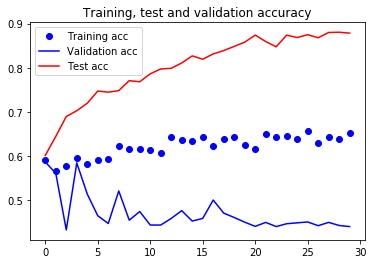

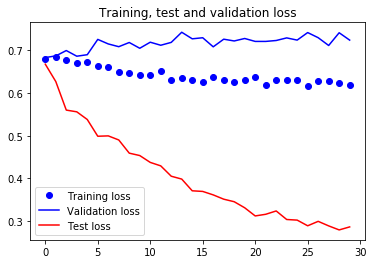

In [14]:
import matplotlib.pyplot as plt

accTe = history.history['acc']
lossTe = history.history['loss']
print('A acurácia do teste é de:', accTe[29])
print('A perda do teste é de:', lossTe[29])
print('A acurácia da validação é de:', val_acc[29])
print('A perda da validação é de:', val_loss[29])
epochs = range(len(accTe))

plt.plot(epochs, accTR, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, accTe, 'r', label='Test acc')
plt.title('Training, test and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, lossTR, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, lossTe, 'r', label='Test loss')
plt.title('Training, test and validation loss')
plt.legend()

plt.show()